In [1]:
import argparse
import os
import time
import math
import numpy as np
import random
import sys
import json

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from utils import to_gpu, Corpus, batchify
from models import Seq2Seq2Decoder, Seq2Seq, MLP_D, MLP_G, MLP_Classify
import shutil

from bpemb import BPEmb  # for decoding BPE tokens

## Load the data and model

In [2]:
# Hard code global variables that were command line arguments in the training script
OUTF = "yelp_example"
MODELF = "model_output_128_128_128_NoBatchNorm"
VOCAB_SIZE = 8000
MAXLEN = 30
LOWERCASE = True
EMSIZE = 300
NHIDDEN = 512
BATCH_SIZE = 64
NLAYERS = 1
NOISE_R = 0.1
DROPOUT = 0.0
HIDDEN_INIT = True
Z_SIZE = 32
ARCH_CLASSIFY = '128-128-128' 
ARCH_D = '128-128'
ARCH_G = '128-128'
LR_AE = 1
LR_GAN_G = 1e-04
LR_GAN_D = 1e-04
LR_CLASSIFY = 1e-04
BETA1 = 0.4
CUDA = True
SEED = 1111
LAMBDA_CLASS = 1
CLIP = 1
TEMP = 1
LOG_INTERVAL = 200
NITERS_GAN_SCHEDULE = ''
GRAD_LAMBDA = 0.01
GAN_GP_LAMBDA = 0.1
EPOCHS = 0
NITERS_AE = 1
NITERS_GAN_G = 1
NITERS_GAN_D = 5
NITERS_GAN_AE = 1
NOISE_ANNEAL = 0.9995
DATA_PATH = './data/'
ADVERSARIAL_DATA_PATH = './adversarial_data/'

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# make output directory if it doesn't already exist
if not os.path.isdir(OUTF):
    os.makedirs(OUTF)

# Set the random seed manually for reproducibility.
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    if not CUDA:
        print("WARNING: You have a CUDA device, "
              "so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(SEED)

In [5]:
# (Path to textfile, Name, Use4Vocab)
datafiles = [(os.path.join(DATA_PATH, "test1.txt"), "test1", False),
             (os.path.join(DATA_PATH, "test0.txt"), "test2", False),
             (os.path.join(DATA_PATH, "train1.txt"), "train1", True),
             (os.path.join(DATA_PATH, "train2.txt"), "train2", True)]
             
             
# if loading adversarial data, list the files here
datafiles += [(os.path.join(ADVERSARIAL_DATA_PATH,
                               ADV_SUBDIRECTORY,
                               "test1 eps_0.005 attack_fgsm.txt"),
                  "ad_test1", False),
                 (os.path.join(ADVERSARIAL_DATA_PATH,
                               ADV_SUBDIRECTORY,
                               "test2 eps_0.005 attack_fgsm.txt"),
                  "ad_test2", False),
                 (os.path.join(ADVERSARIAL_DATA_PATH,
                               ADV_SUBDIRECTORY,
                               "train1 eps_0.05 attack_fgsm.txt"),
                  "ad_train1", False),
                 (os.path.join(ADVERSARIAL_DATA_PATH,
                               ADV_SUBDIRECTORY,
                               "train2 eps_0.05 attack_fgsm.txt"),
                  "ad_train2", False)]

In [9]:
# Load data

# if vocabdict exists, load it
if os.path.exists(os.path.join(OUTF, 'vocab.json')):
    with open(os.path.join(OUTF, 'vocab.json')) as f:
        vocabdict = json.load(f)
else:
    vocabdict = None


label_ids = {"pos": 1, "neg": 0}
id2label = {1:"pos", 0:"neg"}

# (Path to textfile, Name, Use4Vocab)
datafiles = [(os.path.join(DATA_PATH, "test1.txt"), "test1", False),
             (os.path.join(DATA_PATH, "test0.txt"), "test2", False),
             (os.path.join(DATA_PATH, "train1.txt"), "train1", True),
             (os.path.join(DATA_PATH, "train2.txt"), "train2", True)]
             
# if loading adversarial data, this is the directory of the adv. dataset
ADV_SUBDIRECTORY = 'fgsm_eps_005'
    
# if loading adversarial data, list the files here
datafiles += [(os.path.join(ADVERSARIAL_DATA_PATH,
                               ADV_SUBDIRECTORY,
                               "test1 eps_0.005 attack_fgsm.txt"),
                  "ad_test1", False),
                 (os.path.join(ADVERSARIAL_DATA_PATH,
                               ADV_SUBDIRECTORY,
                               "test2 eps_0.005 attack_fgsm.txt"),
                  "ad_test2", False)]

corpus = Corpus(datafiles,
                maxlen=MAXLEN,
                vocab_size=VOCAB_SIZE,
                lowercase=LOWERCASE,
                vocab=vocabdict)

# dumping vocabulary
with open('{}/vocab.json'.format(OUTF), 'w') as f:
    json.dump(corpus.dictionary.word2idx, f)

# save arguments
ntokens = len(corpus.dictionary.word2idx)
print("Vocabulary Size: {}".format(ntokens))

eval_batch_size = 100
test1_data = batchify(corpus.data['test1'], eval_batch_size, shuffle=False)
test2_data = batchify(corpus.data['test2'], eval_batch_size, shuffle=False)
train1_data = batchify(corpus.data['train1'], BATCH_SIZE, shuffle=False)
train2_data = batchify(corpus.data['train2'], BATCH_SIZE, shuffle=False)

# if loading an adversarial dataset:
adtest1_data = batchify(corpus.data['ad_test1'], eval_batch_size, shuffle=False)
adtest2_data = batchify(corpus.data['ad_test2'], eval_batch_size, shuffle=False)

Number of sentences dropped from ./data/test1.txt: 0 out of 76392 total
Number of sentences dropped from ./data/test0.txt: 5 out of 50278 total
Number of sentences dropped from ./data/train1.txt: 1 out of 267314 total
Number of sentences dropped from ./data/train2.txt: 4 out of 176787 total
Number of sentences dropped from ./adversarial_data/fgsm_eps_005/test1 eps_0.005 attack_fgsm.txt: 0 out of 7432 total
Number of sentences dropped from ./adversarial_data/fgsm_eps_005/test2 eps_0.005 attack_fgsm.txt: 1 out of 7227 total
Vocabulary Size: 8004
763 batches
502 batches
4176 batches
2762 batches
74 batches
72 batches


In [ ]:
# Build the models

ntokens = len(corpus.dictionary.word2idx)
autoencoder = Seq2Seq2Decoder(emsize=EMSIZE,
                      nhidden=NHIDDEN,
                      ntokens=ntokens,
                      nlayers=NLAYERS,
                      noise_r=NOISE_R,
                      hidden_init=HIDDEN_INIT,
                      dropout=DROPOUT,
                      gpu=CUDA)

gan_gen = MLP_G(ninput=Z_SIZE, noutput=NHIDDEN, layers=ARCH_G)
gan_disc = MLP_D(ninput=NHIDDEN, noutput=1, layers=ARCH_D)
classifier = MLP_Classify(ninput=NHIDDEN, noutput=1, layers=ARCH_CLASSIFY)
g_factor = None

print(autoencoder)
print(gan_gen)
print(gan_disc)
print(classifier)

optimizer_ae = optim.SGD(autoencoder.parameters(), lr=LR_AE)
optimizer_gan_g = optim.Adam(gan_gen.parameters(),
                             lr=LR_GAN_G,
                             betas=(BETA1, 0.999))
optimizer_gan_d = optim.Adam(gan_disc.parameters(),
                             lr=LR_GAN_D,
                             betas=(BETA1, 0.999))
#### classify
optimizer_classify = optim.Adam(classifier.parameters(),
                                lr=LR_CLASSIFY,
                                betas=(BETA1, 0.999))

criterion_ce = nn.CrossEntropyLoss()

if CUDA:
    autoencoder = autoencoder.cuda()
    gan_gen = gan_gen.cuda()
    gan_disc = gan_disc.cuda()
    classifier = classifier.cuda()
    criterion_ce = criterion_ce.cuda()

In [ ]:
# for byte-pair encoding
BPE_VOCAB_SIZE=25000
BPE_DIM=300
bpemb_en = BPEmb(lang="en", vs=BPE_VOCAB_SIZE, dim=BPE_DIM)

def recover_original_sentence(source_batch):
    """
    Given a sequence of tokens, recover the original text sentence.
    
    Returns:
        List of sentences (strings)
    """
    original_sentences = []
    indices = source_batch.numpy()
    for idx in indices:
        words = [corpus.dictionary.idx2word[x] for x in idx if x > 1]
        original_sentences.append(bpemb_en.decode(words))
    return original_sentences

def generate_sentences_from_embedding(whichclass, embedded_sentences_batch, sample=False):
    """
    Given a sentence embedding, decode into text.
    
    Input:
        sample: If False, perform greedy decoding. If True, sample from distribution.
        
    Returns:
        List of sentences (strings)
    """
    decoded_sentences = []
    max_indices = autoencoder.generate(whichclass, embedded_sentences_batch, maxlen=50, sample=sample)
    max_indices = max_indices.data.cpu().numpy()
    for idx in max_indices:
        # generated sentence
        words = [corpus.dictionary.idx2word[x] for x in idx]
        # truncate sentences to first occurrence of <eos>
        truncated_sent = []
        for w in words:
            if w != '<eos>':
                truncated_sent.append(w)
            else:
                break
        decoded_sentences.append(bpemb_en.decode(truncated_sent))
    return decoded_sentences

def load_model(modelf=MODELF):
    """Load weights for the classifier and autoencoder from the directory modelf"""
    if os.path.exists('{}/autoencoder_model.pt'.format(modelf)):
        autoencoder.load_state_dict(torch.load('{}/autoencoder_model.pt'.format(modelf)))
    if os.path.exists('{}/classifier_model.pt'.format(modelf)):            
        classifier.load_state_dict(torch.load('{}/classifier_model.pt'.format(modelf)))

def fgsm_attack(sentence_embedding, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_embedding = sentence_embedding + epsilon*sign_data_grad
    # Clip within normal range for embedding
    perturbed_embedding = torch.clamp(perturbed_embedding, -0.34, 0.32)
    return perturbed_embedding
    
def evaluate_classifier_both_labels(data_1, data_2,
                                    outputs_batched=False,
                                    perturb=None,
                                    epsilon=0.0,
                                    include_codes=False,
                                    pgd_iters=40,
                                    alpha=.0005,
                                    sample=False):
    """Evaluate the classifier for both labels"""
    output_1 = evaluate_classifier(1, data_1,
                                   outputs_batched=outputs_batched,
                                   perturb=perturb,
                                   epsilon=epsilon,
                                   include_codes=include_codes,
                                   pgd_iters=pgd_iters,
                                   alpha=alpha,
                                   sample=sample)
    output_2 = evaluate_classifier(2, data_2,
                                   outputs_batched=outputs_batched,
                                   perturb=perturb,
                                   epsilon=epsilon,
                                   include_codes=include_codes,
                                   pgd_iters=pgd_iters,
                                   alpha=alpha,
                                   sample=sample)

    if include_codes:
        loss_1, pred_1, labels_1, decoded_1, codes_1 = output_1
        loss_2, pred_2, labels_2, decoded_2, codes_2 = output_2
    else:
        loss_1, pred_1, labels_1, decoded_1 = output_1
        loss_2, pred_2, labels_2, decoded_2 = output_2
    
    labels = torch.cat((labels_1, labels_2))
    pred = torch.cat((pred_1, pred_2))
    acc = pred.eq(labels).float().mean().item()
    
    if include_codes:
        return acc, pred, labels, decoded_1, decoded_2, np.vstack([np.vstack(codes_1), np.vstack(codes_2)])
    else:
        return acc, pred, labels, decoded_1, decoded_2
        

def evaluate_classifier(whichclass, data_source,
                        outputs_batched=False,
                        perturb=None,
                        epsilon=0.0,
                        include_codes=False,
                        pgd_iters=40,
                        alpha=.0005,
                        sample=False):
    """
    Evaluate a classifier with data corresponding to a single class.

    input:
        perturb: None, 'pgd', or 'fgsm'
    """
    classifier.eval()
    autoencoder.eval()
    total_loss = 0
    all_pred = []
    all_labels = []
    source_sents = []
    decoded_sents = []
    if include_codes:
        all_codes = []

    for i, batch in enumerate(data_source):
        source, target, lengths = batch
        source = to_gpu(CUDA, Variable(source))
        labels = to_gpu(CUDA, Variable(torch.zeros(source.size(0)).fill_(whichclass-1)))
        
        code = autoencoder(0, source, lengths, noise=False, encode_only=True).detach()
        
        if include_codes:  # return codes for inspection
            all_codes.append(code.cpu().numpy())

        code.requires_grad = True
        scores = classifier(code)
        classify_loss = F.binary_cross_entropy(scores.squeeze(1), labels)
        
        if perturb == 'fgsm':
            classifier.zero_grad()
            classify_loss.backward()
            code_grad = code.grad.data
            perturbed_code = fgsm_attack(code, epsilon, code_grad)
            
            # decode embedded sentence and convert to words
            decoded_sents.extend(generate_sentences_from_embedding(whichclass, perturbed_code, sample=sample))
            
            scores = classifier(perturbed_code)
            classify_loss = F.binary_cross_entropy(scores.squeeze(1), labels)
        elif perturb == 'pgd':
            # alpha: step size
            # epsilon: max perturbation (ball)
            perturbed_code = code.clone().detach()
            for i in range(pgd_iters):
                perturbed_code.requires_grad = True
                scores = classifier(perturbed_code)
                tmp_loss = F.binary_cross_entropy(scores.squeeze(1), labels)
                classifier.zero_grad()
                tmp_loss.backward(retain_graph=True)

                # step in the direction of the gradient
                perturbed_code = perturbed_code + alpha * perturbed_code.grad.sign()
                
                # Workaround as PyTorch doesn't have elementwise clip
                # from: https://gist.github.com/oscarknagg/45b187c236c6262b1c4bbe2d0920ded6#file-projected_gradient_descent-py
                perturbed_code = torch.max(torch.min(perturbed_code, code + epsilon), code - epsilon).detach()
                perturbed_code = torch.clamp(perturbed_code, -0.34, 0.32)
                
            # decode embedded sentence and convert to words
            decoded_sents.extend(generate_sentences_from_embedding(whichclass, perturbed_code))
            
            scores = classifier(perturbed_code)
            classify_loss = F.binary_cross_entropy(scores.squeeze(1), labels)

        else:
            # decode embedded sentence and convert to words
            decoded_sents.extend(generate_sentences_from_embedding(whichclass, code))
            

        pred = scores.data.round().squeeze(1)
        total_loss += classify_loss.cpu().item()

        all_pred.append(pred)
        all_labels.append(labels)
        
    if outputs_batched == False:
        if include_codes:
            return total_loss/len(data_source), torch.cat(all_pred), torch.cat(all_labels), decoded_sents, all_codes
        else:
            return total_loss/len(data_source), torch.cat(all_pred), torch.cat(all_labels), decoded_sents
        
    if include_codes:
        return total_loss/len(data_source), all_pred, all_labels, decoded_sents, all_codes
    else:
        return total_loss/len(data_source), all_pred, all_labels, decoded_sents

## White-Box Setting: Evaluate Under FGSM and PGD Attacks

### FGSM

In [17]:
# evaluate the following models
models = [
    "model_output_0.0005_adtrain_noclip", 
    "model_output_0.001_adtrain_noclip", 
    "model_output_0.05_adtrain/20 epochs",
    "model_output_0.25_adtrain/20 epochs",
    "model_output_pgd_40_0.005_0.0005",
    "model_output_128_128_128_NoBatchNorm"]

In [18]:
# Evaluate under FGSM attack
for modelf in models:
    load_model(modelf=modelf)
    print("Loaded model:", modelf)
    for epsilon in [0.0005, 0.001, .005, .01, 0.05, 0.1, 0.25, 0.5]:
        print('Epsilon:', epsilon)
        test_acc, _, _, _, _ = evaluate_classifier_both_labels(test1_data, test2_data,
                                                               perturb='fgsm',
                                                               epsilon=epsilon,
                                                               include_codes=False)
        print('Accuracy: Adversarial dataset - Test set {}'.format(test_acc))
    print()

Loaded model: model_output_0.0005_adtrain_noclip

Epsilon: 0.02
Accuracy: Adversarial dataset - Test set 0.0
Loaded model: model_output_0.001_adtrain_noclip

Epsilon: 0.02
Accuracy: Adversarial dataset - Test set 6.324111018329859e-05
Loaded model: model_output_0.05_adtrain/20 epochs

Epsilon: 0.02
Accuracy: Adversarial dataset - Test set 0.9255415797233582
Loaded model: model_output_0.25_adtrain/20 epochs

Epsilon: 0.02
Accuracy: Adversarial dataset - Test set 0.0015415020752698183
Loaded model: model_output_pgd_40_0.005_0.0005

Epsilon: 0.02
Accuracy: Adversarial dataset - Test set 0.0835968405008316
Loaded model: model_output_128_128_128_NoBatchNorm

Epsilon: 0.02
Accuracy: Adversarial dataset - Test set 0.0


### PGD

In [11]:
# Evaluate under PGD attack

modelf = "model_output_0.0005_adtrain_noclip"
load_model(modelf=modelf)
print("Loaded model:", modelf)

# attack configurations
configs = [(0.005, 0.0005, 1),
           (0.005, 0.0005, 2),
           (0.005, 0.0005, 5),
           (0.005, 0.0005, 10),
           (0.005, 0.0005, 20),
           (0.005, 0.0005, 40)
]

for epsilon, alpha, iters in configs:
    print("{} {} {}".format(epsilon, alpha, iters))
    test_acc, _, _, _, _ = evaluate_classifier_both_labels(test1_data, test2_data,
                                                           perturb='pgd',
                                                           epsilon=epsilon,
                                                           alpha=alpha,
                                                           include_codes=False,
                                                           pgd_iters=iters)
    print('Accuracy: Adversarial dataset - Test set {}'.format(test_acc))
    print()

Loaded model: model_output_0.0005_adtrain_noclip
0.005 0.0005 1
Accuracy: Adversarial dataset - Train set 0.8510534763336182
Accuracy: Adversarial dataset - Test set 0.8369882106781006

0.005 0.0005 2
Accuracy: Adversarial dataset - Train set 0.7692170739173889
Accuracy: Adversarial dataset - Test set 0.7545692324638367

0.005 0.0005 5
Accuracy: Adversarial dataset - Train set 0.4109365940093994
Accuracy: Adversarial dataset - Test set 0.4018498361110687

0.005 0.0005 10
Accuracy: Adversarial dataset - Train set 0.03746351599693298
Accuracy: Adversarial dataset - Test set 0.038339924067258835

0.005 0.0005 20
Accuracy: Adversarial dataset - Train set 0.0297478549182415
Accuracy: Adversarial dataset - Test set 0.030774705111980438

0.005 0.0005 40
Accuracy: Adversarial dataset - Train set 0.028464164584875107
Accuracy: Adversarial dataset - Test set 0.029343875125050545



## Generate a decoded adversarial dataset for black-box setting experiment

In [61]:
import pandas as pd

def create_adversarial_dataset(data1, data2,
                               phase='train',
                               perturb=None, epsilon=0, alpha=.0005, pgd_iters=40,  # perturbation configuration
                               directory='./adversarial_data/',
                               sample=False # for decoding
                              ):
    _, pred_1, labels_1, decoded_1 = evaluate_classifier(1, data1, outputs_batched=True, perturb=None)
    _, pred_2, labels_2, decoded_2 = evaluate_classifier(2, data2, outputs_batched=True, perturb=None)

    # check which examples are classified correctly
    data1_correct = []
    data2_correct = []

    for i, data in enumerate(data1):
        batch_pred = pred_1[i].cpu().numpy()
        batch_labels = labels_1[i].cpu().numpy()

        correctly_classified_indices = np.where(batch_pred == batch_labels)[0]
        source, target, length = data
        source_correct = source[correctly_classified_indices]
        target_correct = target[correctly_classified_indices]
        length_correct = [length[i] for i in correctly_classified_indices]
        data1_correct.append((source_correct, target_correct, length_correct))

    for i, data in enumerate(data2):
        batch_pred = pred_2[i].cpu().numpy()
        batch_labels = labels_2[i].cpu().numpy()

        correctly_classified_indices = np.where(batch_pred == batch_labels)[0]
        source, target, length = data

        source_correct = source[correctly_classified_indices]
        target_correct = target[correctly_classified_indices]
        length_correct = [length[i] for i in correctly_classified_indices]
        data2_correct.append((source_correct, target_correct, length_correct))

    # generate adversarial examples for the correctly classified examples
    _, _, _, adv_decoded_1, adv_decoded_2 = evaluate_classifier_both_labels(data1_correct, data2_correct,
                                                                            outputs_batched=False,
                                                                            perturb=perturb,
                                                                            epsilon=epsilon,
                                                                            alpha=alpha,
                                                                            pgd_iters=pgd_iters,
                                                                            sample=sample)
    
    # also decode the original sentences for comparison
    _, _, _, source_decoded_1, source_decoded_2 = evaluate_classifier_both_labels(data1_correct, data2_correct,
                                                                                  outputs_batched=False,
                                                                                  perturb=None,
                                                                                  sample=sample)
    
    if not os.path.exists(directory):
        os.mkdir(directory)
    
    # Create new datasets of decoded adversarial sentences, but only those that 
    # do not exactly match their unperturbed counterpart after both are decoded
    with open(directory + '{}1 eps_{} attack_{}.txt'.format(phase, epsilon, perturb), 'w') as f:
        for s, d in zip(source_decoded_1, adv_decoded_1):
            if s != d:
                f.write("%s\n" % d)

    with open(directory + '{}2 eps_{} attack_{}.txt'.format(phase, epsilon, perturb), 'w') as f:
        for s, d in zip(source_decoded_2, adv_decoded_2):
            if s != d:
                f.write("%s\n" % d)

    # For inspection, write all of the data to file
    # (for examples that were initially classified correctly by the classifier)
    original_sentences_1 = []
    for s, t, l in data1_correct:
        original_sentences_1.extend(recover_original_sentence(s))
        
    original_sentences_2 = []
    for s, t, l in data2_correct:
        original_sentences_2.extend(recover_original_sentence(s))

    df_1 = pd.DataFrame(list(zip(original_sentences_1,
                                 adv_decoded_1,
                                 source_decoded_1)), 
                   columns =['original', 'adv_decoded', 'original_decoded']) 
    df_1['label'] = 1

    df_2 = pd.DataFrame(list(zip(original_sentences_2,
                                 adv_decoded_2,
                                 source_decoded_2)), 
                   columns =['original', 'adv_decoded', 'original_decoded']) 
    df_2['label'] = 2

    df = pd.concat([df_1, df_2], ignore_index=True)
    df['included_in_adv_dataset'] = df['adv_decoded'] != df['original_decoded']
    df.to_csv(directory + 'inspect {} eps_{} attack_{}.csv'.format(phase, epsilon, perturb))

In [43]:
# Perturbations will be applied to embedded sentences using this model:
load_model("model_output_128_128_128_NoBatchNorm")

create_adversarial_dataset(test1_data, test2_data,  # datasets to be perturbed
                           'test',
                           perturb='pgd',  # perturbation configuration
                           epsilon=0.5,
                           alpha=0.05,
                           pgd_iters=20,
                           directory='./adversarial_data/pgd_eps_5_alpa_05_iters_20/')

## Black-Box Setting: Evaluate models against a decoded adversarial dataset

In [124]:
# evaluate the following models
models = [
    "model_output_0.0005_adtrain_noclip", 
    "model_output_0.001_adtrain_noclip",
    "model_output_0.05_adtrain/20 epochs",
    "model_output_0.25_adtrain/20 epochs",
    "model_output_pgd_40_0.005_0.0005",
    "model_output_128_128_128_NoBatchNorm"]

for modelf in models:
    load_model(modelf=modelf)
    print("Loaded model:", modelf)
    
    # evaluate the classifier against the adversarial dataset
    test_acc, pred, labels, _, _ = evaluate_classifier_both_labels(adtest1_data, adtest2_data,
                                                                   outputs_batched=False,
                                                                   perturb=None)
    print('Accuracy: Adversarial dataset - Test set {}'.format(test_acc))
    print()

Loaded model: model_output_0.0005_adtrain_noclip
Accuracy: Adversarial dataset - Test set 0.89693284034729



### For further inspection, keep only the adv. examples that were misclassified

In [114]:
original_sentences_1 = []
for s, t, l in adtest1_data:
    original_sentences_1.extend(recover_original_sentence(s))

original_sentences_2 = []
for s, t, l in adtest2_data:
    original_sentences_2.extend(recover_original_sentence(s))
    
sentences = np.array(original_sentences_1 + original_sentences_2)
df = pd.DataFrame([sentences, labels.cpu().numpy(), pred.cpu().numpy()]).T
df.columns = ['original_sentence', 'label', 'pred']

with open('./adversarial_data/pgd_eps_05_alpha_005_iters_20_only_misclassified_decoded/test1 eps_0.05 attack_pgd.txt', 'w') as f:
    for d in df[(df.label != df.pred) & (df.label == 0)]['original_sentence']:
            f.write("%s\n" % d)

with open('./adversarial_data/pgd_eps_05_alpha_005_iters_20_only_misclassified_decoded/test2 eps_0.05 attack_pgd.txt', 'w') as f:
    for d in df[(df.label != df.pred) & (df.label == 1)]['original_sentence']:
            f.write("%s\n" % d)

## Inspect the distributions of the embedded sentences
We examine the distribution of embedded sentences before perturbation to understand the range of realistic values.

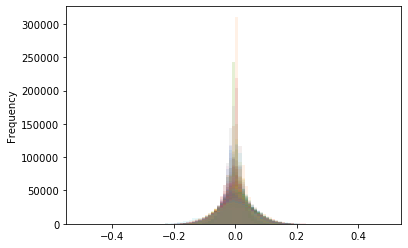

In [77]:
for i in range(512):
    pd.Series(codes[:, i]).plot.hist(alpha=0.1, bins=np.arange(-.5, .5, .01))

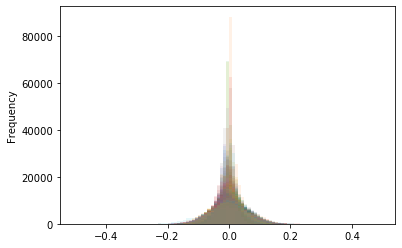

In [73]:
for i in range(512):
    pd.Series(codes[:, i]).plot.hist(alpha=0.1, bins=np.arange(-.5, .5, .01))

## Perplexity
Calculate the perplexity of our original and perturbed sentences against a pretrained LM.

In [22]:
# free up gpu
del autoencoder
del classifier
torch.cuda.empty_cache()

In [23]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
lm = GPT2LMHeadModel.from_pretrained('gpt2')
lm = lm.cuda()
lm.eval()

In [32]:
def score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    with torch.no_grad():
        tensor_input = tensor_input.cuda()
        outputs = lm(tensor_input, labels=tensor_input)
    loss = outputs[0]  
    return loss.item()

In [33]:
def get_ppl(sentences):
    """
    Assume sentences is a list of strings (space delimited sentences)
    """
    total_nll = 0
    total_wc = 0
    for sent in sentences:
        words = sent.strip().split()
        sent_score = score(sent)
        word_count = len(words)
        total_wc += word_count
        total_nll += sent_score
    ppl = math.exp(total_nll/total_wc)
    return ppl

In [35]:
get_ppl(np.array(results['source'])[idx])

1.7038252596041783

In [41]:
# indices of adversarial examples
e = 0.0015
idx = np.logical_and(
    np.array(results['source']) != np.array(results[e]['decoded']),
    ~results[e]['labels'].eq(results[e]['pred']).data.cpu().numpy())

get_ppl(np.array(results[e]['decoded'])[idx])

1.7774270590392736